<a href="https://colab.research.google.com/github/mohsenMahmoodzadeh/Image-Caption-classification-with-tensorflow-Keras/blob/master/Phase_01_Text_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Import Libraries

In [ ]:
!pip install tensorflow-text
!pip install tensorflow-hub

In [2]:
import os
import shutil

import numpy as np
import matplotlib.pyplot as plt
import string
import re
import pandas as pd
import seaborn as sn

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

tf.get_logger().setLevel('ERROR')

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')

## Import Datasets

In [3]:
TRAIN_DATA_DIR = "/content/drive/MyDrive/dataset/train/sentences/"
TEST_DATA_DIR = "/content/drive/MyDrive/dataset/test/sentences/"

In [4]:
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE
seed = 1337

In [5]:
raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    TRAIN_DATA_DIR,
    batch_size = batch_size,
    label_mode="categorical",
    validation_split=0.2,
    subset='training',
    seed= seed 
)

Found 532 files belonging to 19 classes.
Using 426 files for training.


In [6]:
raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    TRAIN_DATA_DIR,
    batch_size = batch_size,
    label_mode="categorical",
    validation_split=0.2,
    subset='validation',
    seed= seed 
)

Found 532 files belonging to 19 classes.
Using 106 files for validation.


In [7]:
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    TEST_DATA_DIR,
    batch_size=batch_size,
    label_mode="categorical"
)

Found 380 files belonging to 19 classes.


In [8]:
print(f"Number of batches in raw_train_ds: {raw_train_ds.cardinality()}")
print(f"Number of batches in raw_val_ds: {raw_val_ds.cardinality()}")
print(f"Number of batches in raw_test_ds: {raw_test_ds.cardinality()}")

Number of batches in raw_train_ds: 14
Number of batches in raw_val_ds: 4
Number of batches in raw_test_ds: 12


## Data Preprocessing

In [ ]:
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, "<br />", " ")
    return tf.strings.regex_replace(
        stripped_html, f"[{re.escape(string.punctuation)}]", ""
    )

max_features = None
sequence_length = 256

vectorize_layer = tf.keras.layers.TextVectorization(
    standardize=custom_standardization,
    output_mode="int",
    output_sequence_length=sequence_length,
)

In [ ]:
text_ds = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(text_ds)

In [ ]:
max_features = vectorize_layer.vocabulary_size()
vocab = vectorize_layer.get_vocabulary()

In [ ]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

train_ds = train_ds.cache().prefetch(buffer_size=10)
val_ds = val_ds.cache().prefetch(buffer_size=10)
test_ds = test_ds.cache().prefetch(buffer_size=10)

In [ ]:
word_index = dict(zip(vocab, range(len(vocab))))

## Word Embedding

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2022-01-24 21:28:25--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-01-24 21:28:25--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-01-24 21:28:25--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [ ]:
path_to_glove_file = '/content/glove.6B.100d.txt'

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [ ]:
num_tokens = len(vocab) + 2
embedding_dim = 100
hits = 0
misses = 0

embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 2016 words (66 misses)


## Building model

In [ ]:
def create_model(max_features, embedding_dim):
    
  num_classes = 19
      
  inputs = tf.keras.Input(shape=(None,), dtype="int64")
  x = tf.keras.layers.Embedding(num_tokens, 
                                embedding_dim, 
                                embeddings_initializer= tf.keras.initializers.Constant(embedding_matrix),
                                trainable=False
                                )(inputs)
  
  x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, 
                                                         return_sequences=True, 
                                                         dropout=0.1,
                                                         recurrent_dropout=0.1))(x)
  
  x = tf.keras.layers.Conv1D(64, kernel_size=3, padding="valid", kernel_initializer="glorot_uniform")(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Conv1D(32, kernel_size=3, padding="valid", kernel_initializer="glorot_uniform")(x)
  x = tf.keras.layers.BatchNormalization()(x)
  
  x = tf.keras.layers.GlobalMaxPooling1D()(x)

  preds = tf.keras.layers.Dense(num_classes, activation="softmax")(x)

  model = tf.keras.Model(inputs, preds)

  return model


## Training model

In [ ]:
model = create_model(max_features, embedding_dim)
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'])

In [ ]:
epochs = 30
es = tf.keras.callbacks.EarlyStopping(patience=2)
history = model.fit(
    train_ds, 
    validation_data= val_ds, 
    callbacks= [es],
    epochs= epochs)

Epoch 1/30
14/14 [==============================] - 28s 2s/step - loss: 3.6891 - accuracy: 0.0915 - val_loss: 3.3183 - val_accuracy: 0.0943
Epoch 2/30
14/14 [==============================] - 21s 1s/step - loss: 2.4938 - accuracy: 0.2136 - val_loss: 2.9485 - val_accuracy: 0.0943
Epoch 3/30
14/14 [==============================] - 21s 1s/step - loss: 1.9737 - accuracy: 0.4061 - val_loss: 2.6677 - val_accuracy: 0.1132
Epoch 4/30
14/14 [==============================] - 20s 1s/step - loss: 1.5329 - accuracy: 0.5446 - val_loss: 2.4942 - val_accuracy: 0.2642
Epoch 5/30
14/14 [==============================] - 21s 1s/step - loss: 1.1833 - accuracy: 0.6667 - val_loss: 2.3439 - val_accuracy: 0.3585
Epoch 6/30
14/14 [==============================] - 20s 1s/step - loss: 0.8604 - accuracy: 0.7840 - val_loss: 2.2872 - val_accuracy: 0.4434
Epoch 7/30
14/14 [==============================] - 20s 1s/step - loss: 0.6103 - accuracy: 0.8662 - val_loss: 2.2136 - val_accuracy: 0.6321
Epoch 8/30
14/14 [==

Text(0.5, 1.0, 'Training and validation loss')

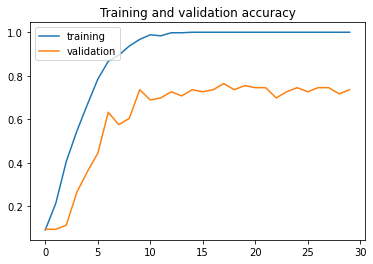

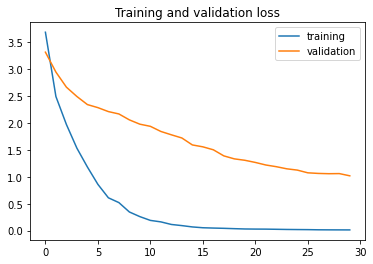

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, label = "training")
plt.plot(epochs, val_acc, label = "validation")
plt.legend(loc="upper left")
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, label = "training")
plt.plot(epochs, val_loss, label = "validation")
plt.legend(loc="upper right")
plt.title('Training and validation loss')
plt.show()

## Evaluation

In [ ]:
model.evaluate(test_ds)

12/12 [==============================] - 3s 194ms/step - loss: 1.0467 - accuracy: 0.7368


[1.0466973781585693, 0.7368420958518982]

## Saving model

In [ ]:
model.save('glove_model.h5')

## Text Classification With Bert



In [ ]:
label_map = {
    0 : 'aeroplane', 1 : 'bicycle', 2 : 'bird', 3 : 'boat', 
    4 : 'bus', 5 : 'car', 6 : 'cat', 7 : 'chair', 8 : 'cow',
    9 : 'diningtable', 10 : 'dog', 11 : 'horse', 12 : 'motorbike',
    13 : 'person', 14 : 'pottedplant', 15 : 'sheep', 16 : 'sofa',
    17 : 'train', 18 : 'tvmonitor'
  }

CATEGORIES = list(label_map.values())

In [9]:
def read_file(filename):
    f = open(filename, 'r')
    lines = f.readlines()
    return lines

In [10]:
def prepare_train_data(TRAIN_DATA_DIR, CATEGORIES):
    train_data = []
    path = ""
    for category in CATEGORIES:
        temp = []
        path = os.path.join(TRAIN_DATA_DIR, category)
        class_num = CATEGORIES.index(category)
        for filename in os.listdir(path):
            file_path = os.path.join(path, filename)
            try:
                lines = read_file(file_path)
                for line in lines:
                    temp.append(line)

            except Exception as e:
                print(str(e))
        
        for line in temp:
            train_data.append((line, class_num))
    
    return train_data

In [11]:
def prepare_test_data(TEST_DATA_DIR, CATEGORIES):
    test_data = []
    path = ""
    for category in CATEGORIES:
        temp = []
        path = os.path.join(TRAIN_DATA_DIR, category)
        class_num = CATEGORIES.index(category)
        for filename in os.listdir(path):
            file_path = os.path.join(path, filename)
            file = file_path
            try:
                lines = read_file(file)
                for line in lines:
                    temp.append(line)

            except Exception as e:
                print(str(e))
        
        for line in temp:
            test_data.append((line, class_num))
    return test_data

In [13]:
training_data = prepare_train_data(TRAIN_DATA_DIR, CATEGORIES)
test_data = prepare_test_data(TEST_DATA_DIR, CATEGORIES)

In [15]:
def extract_X_and_y(data):
  data_dict = {}
  X = []
  y = []
  for example in data:
    X.append(example[0])
    y.append(example[1])
  data_dict['X'] = X
  data_dict['y'] = y
  return data_dict

In [16]:
training_dict = extract_X_and_y(training_data)
X_train = training_dict['X']
y_train = training_dict['y']

In [17]:
test_dict = extract_X_and_y(test_data)
X_test = test_dict['X']
y_test = test_dict['y']

In [19]:
def clean_data(text):  
  text = text.replace("\n", " ")
  text = text.replace("\r", " ")
  text = text.replace("\t", " ")
  word_tokens= text.lower().strip().split()
  le=WordNetLemmatizer()
  stop_words= set(stopwords.words("english"))     
  word_tokens= [le.lemmatize(w) for w in word_tokens if not w in stop_words]
  
  cleaned_data=" ".join(word_tokens)
  return cleaned_data

In [20]:
cleaned_X_train = []
for tr_example in X_train:
  cleaned_data = clean_data(tr_example)
  cleaned_X_train.append(cleaned_data)

In [21]:
cleaned_X_test = []
for test_example in X_test:
  cleaned_data = clean_data(test_example)
  cleaned_X_test.append(cleaned_data)

In [22]:
X_train, X_val, y_train, y_val = train_test_split(cleaned_X_train, y_train, test_size=0.3, shuffle=True, random_state=0)

In [40]:
import tensorflow_hub as hub
import tensorflow_text as text

In [41]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [77]:
def get_sentence_embeding(sentences):
    preprocessed_text = bert_preprocess(sentences)
    return bert_encoder(preprocessed_text)['pooled_output']

In [43]:
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(19, activation='softmax', name="output")(l)

model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [58]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
]

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=METRICS)

In [ ]:
es = tf.keras.callbacks.EarlyStopping(patience=2)
epochs = 5

In [59]:
history = model.fit(np.array(X_train), tf.keras.utils.to_categorical(y_train), 
          validation_data=(np.array(X_val), tf.keras.utils.to_categorical(y_val)),
          callbacks= [es],
          epochs=epochs)

Epoch 1/5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
59/59 [==============================] - ETA: 0s - loss: 2.6167 - accuracy: 0.9475 WARNING: AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7f7366244d40> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
59/59 [==============================] - 1026s 17s/step - loss: 2.6167 - accuracy:

In [61]:
model.evaluate(np.array(X_test), tf.keras.utils.to_categorical(y_test))

84/84 [==============================] - 1094s 13s/step - loss: 2.6400 - accuracy: 0.9474


[2.6400163173675537, 0.9474471211433411]

In [78]:
model.save('bert_model.h5')

In [76]:
# y_predicted = model.predict(X_test)
# y_predicted = y_predicted.flatten()

In [65]:
# y_predicted = y_predicted.reshape((2658, 19))

In [67]:
# y_pred = np.argmax(y_predicted, axis=1)

In [73]:
# import numpy as np
# from sklearn.metrics import confusion_matrix, classification_report
# from matplotlib import pyplot as plt
# import seaborn as sn

# # y_predicted = np.where(y_predicted > 0.5, 1, 0)
# cm = confusion_matrix(y_test, y_pred)

In [74]:
# sn.heatmap(cm, annot=True, fmt='d')
# plt.xlabel('Predicted')
# plt.ylabel('Truth')

In [75]:
# print(classification_report(y_test, y_pred))